# The relationship between crime and unemployment

What causes crime? The question has intrigued all from criminologists, to economists to anyone who has read the newspapers. 

Research shows that increasing unemployment rates predict rising crime ([link](https://www.sciencedirect.com/science/article/abs/pii/S0167268119301027)). That sounds suspiciously like common sense. 

Indeed, it seems like all research ever does is do statistical gymnastics and write a paper in Greek so that it can point out the obvious.

This notebook pretty much will try to do the same. Only with simpler stats, and minus the Greek.

Our main variable of interest is the crime index ratio, which you can think of as the number of crimes per 100,000 population. It includes both violent and property crimes, both leading indicators of crime levels in a country.

And we will pose the question, 
#### "how does crime relate to the unemployment rate?"

### First, let's set up the data and visualise it.

In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, geom_histogram, geom_point, geom_bar, geom_col, theme, element_text

In [383]:
# Import data sourced from Department of Statistics Malaysia

# Crime data
# This includes state and national crime indices for 2015 - 2019. 2020 is not yet available.
df = pd.read_csv("crimeindex.csv")

# Unemployment data
df_ue = pd.read_csv("ue_ts.csv")

# Inflation data (Consumer Price Index)
df_cpi = pd.read_csv("cpi.csv")

In [385]:
# Some data cleaning:
# Convert Year variable in df to integer
df['Year'] = pd.to_datetime(df['Year'], format = "%Y")
df['Year'] = df.Year.dt.year

# Briefly glance through the data
display(df)
display(df_ue)
display(df_cpi)

,State,Year,CrimeIndexRatio,CrimeIndex,Population
0,Malaysia,2015,370.50,115544,31186100
1,Malaysia,2016,355.17,112354,31633500
2,Malaysia,2017,309.68,99169,32022600
3,Malaysia,2018,273.80,88662,32382300
4,Malaysia,2019,256.61,83456,32523000
...,...,...,...,...,...
70,W.P. Kuala Lumpur,2015,855.75,15946,1863400
71,W.P. Kuala Lumpur,2016,906.52,16989,1874100
72,W.P. Kuala Lumpur,2017,716.86,13482,1880700
73,W.P. Kuala Lumpur,2018,642.59,12127,1887200


,Year,State,UnemploymentRate
0,2019,Johor,2.7
1,2019,Kedah,2.8
2,2019,Kelantan,4.0
3,2019,Malaysia,3.3
4,2019,Melaka,1.1
...,...,...,...
607,1982,Selangor,2.2
608,1982,Terengganu,2.7
609,1982,W.P Labuan,NaN
610,1982,W.P. Kuala Lumpur,1.9


,Year,State,CPI
0,2015,Malaysia,112.8
1,2016,Malaysia,115.2
2,2017,Malaysia,119.5
3,2018,Malaysia,120.7
4,2019,Malaysia,121.5
...,...,...,...
85,2016,Sarawak,112.7
86,2017,Sarawak,116.0
87,2018,Sarawak,116.7
88,2019,Sarawak,116.8


In [386]:
#Merge all dataframes using keys = Year, State
df = df.merge(df_ue, how = "left", on = ['Year', 'State'])
df = df.merge(df_cpi, how="left", on=['Year', 'State'])

df

,State,Year,CrimeIndexRatio,CrimeIndex,Population,UnemploymentRate,CPI
0,Malaysia,2015,370.50,115544,31186100,3.1,112.8
1,Malaysia,2016,355.17,112354,31633500,3.4,115.2
2,Malaysia,2017,309.68,99169,32022600,3.4,119.5
3,Malaysia,2018,273.80,88662,32382300,3.3,120.7
4,Malaysia,2019,256.61,83456,32523000,3.3,121.5
...,...,...,...,...,...,...,...
70,W.P. Kuala Lumpur,2015,855.75,15946,1863400,3.3,112.4
71,W.P. Kuala Lumpur,2016,906.52,16989,1874100,3.3,115.5
72,W.P. Kuala Lumpur,2017,716.86,13482,1880700,3.1,119.8
73,W.P. Kuala Lumpur,2018,642.59,12127,1887200,2.4,121.5


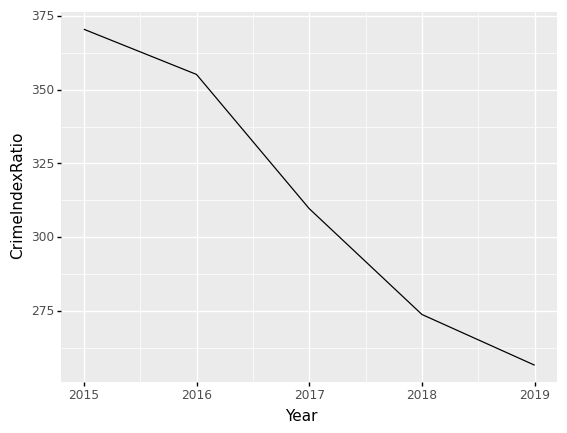

<ggplot: (310094445)>

In [381]:
# Visualise Malaysia's CrimeIndexRatio (CIR)
ggplot(df[df['State']=='Malaysia']) + aes(x='Year', y = 'CrimeIndexRatio') + geom_line()

Findings:
1. Malaysia's CIR was on a downward trend between 2015 - 2019! That's great news! Wonder what caused it.

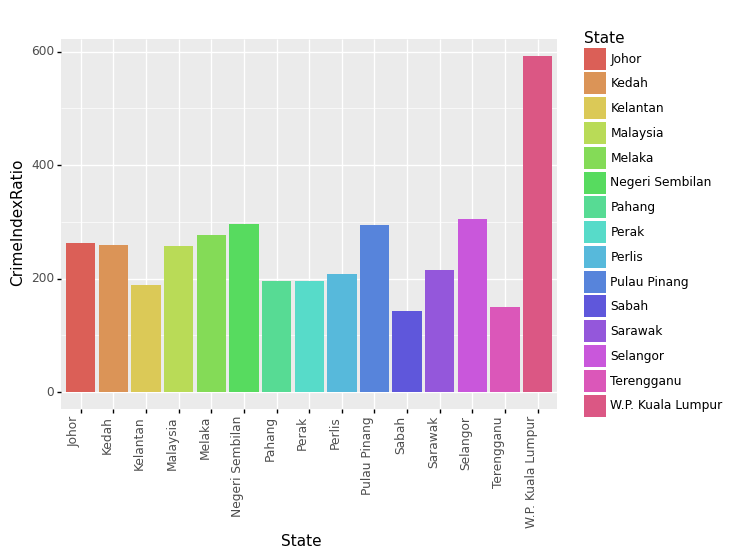

<ggplot: (314528226)>

In [410]:
# Visualise CIR for all states in 2019
(ggplot(df[df['Year']==2019]) + 
 aes(x='State', y = 'CrimeIndexRatio', fill ='State') + 
 geom_col() + 
 theme(axis_text_x=element_text(rotation=90, hjust=1)))

Findings:
1. KL is not the safest place to be! :O
2. Sabah and Terengganu would make good retirement places though.

In [ ]:
# Extract data to create plots in Polymath using Chart.js

#Malaysia line graph
df_country = df[df['State']=='Malaysia']
countrycirvalues = df_country.CrimeIndexRatio.values.tolist()
crimeyear = df_country.Year.tolist()

#State bar graph
df2 = df[df['Year']==2019]

# Sort data by CIR
df2 = df2.sort_values(by='CrimeIndexRatio', ascending = False)
df2_states = df2.State.values.tolist()
df2_cirvalues = df2.CrimeIndexRatio.values.tolist()

### Regress _CrimeIndexRatio_ on _UnemploymentRates_ 

Now on to the fun stuff. Let's explore the relationship between crime and unemployment. We will use a linear regression to do this.

We'll also include consumer price index in our analysis as a way of accounting for economic conditions.

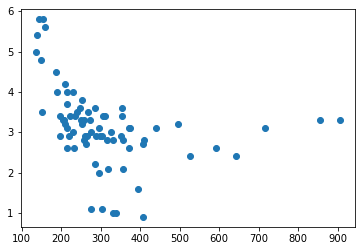

In [413]:
# First, let's check crimeindexratio's correlation with unemployment rate

plt.scatter(df['CrimeIndexRatio'], df['UnemploymentRate'])

Hmm... it seems like unemployment rate is negatively correlated with CIR. This suggests that as unemployment goes up, there are fewer crimes. Doesn't seem like what we thought in the beginning.

But we haven't accounted for the fact that every state has its own unique set of socioeconomic characteristics.

It could be that some states have high unemployment and low CIR simply because people there are just more moral, have fewer opportunities to commit crime, or are more fearful of the law (and if not the law, maybe of God). It could be anything. 

These states would make it seem as if high unemployment is linked to low CIR. What we really want to know is, accounting for the unique conditions of each state, is unemployment rate still negatively linked to CIR?

### Let's do this using an entity fixed effects model.
Where entity = state.
Using an entity fixed effects model means that we think each state has its own unique time-invariant characteristics, and we want to explicitly filter out their impact on the overall relationship between unemployment and crime.


In [414]:
#So let's create a dataset to remove these fixed effects.
df_demean = df.copy()

In [415]:
#Get the means of CIR, unemployment rate and CPI by state
df_demean['Mean_CrimeIndexRatio_byState'] = df_demean.groupby('State').CrimeIndexRatio.transform(np.mean)
df_demean['Mean_UnemploymentRate_byState'] = df_demean.groupby('State').UnemploymentRate.transform(np.mean)
df_demean['Mean_CPI_byState'] = df_demean.groupby('State').CPI.transform(np.mean)

In [416]:
#Get demeaned CIR, unemployment rate and CPI
df_demean['CrimeIndexRatio'] = df_demean['CrimeIndexRatio'] - df_demean['Mean_CrimeIndexRatio_byState']
df_demean['UnemploymentRate'] = df_demean['UnemploymentRate'] - df_demean['Mean_UnemploymentRate_byState']
df_demean['CPI'] = df_demean['CPI'] - df_demean['Mean_CPI_byState']

In [417]:
#Let's see what this looks like
df_demean

,State,Year,CrimeIndexRatio,CrimeIndex,Population,UnemploymentRate,CPI,Mean_CrimeIndexRatio_byState,Mean_UnemploymentRate_byState,Mean_CPI_byState
0,Malaysia,2015,57.348,115544,31186100,-0.20,-5.14,313.152,3.30,117.94
1,Malaysia,2016,42.018,112354,31633500,0.10,-2.74,313.152,3.30,117.94
2,Malaysia,2017,-3.472,99169,32022600,0.10,1.56,313.152,3.30,117.94
3,Malaysia,2018,-39.352,88662,32382300,0.00,2.76,313.152,3.30,117.94
4,Malaysia,2019,-56.542,83456,32523000,0.00,3.56,313.152,3.30,117.94
...,...,...,...,...,...,...,...,...,...,...
70,W.P. Kuala Lumpur,2015,112.946,15946,1863400,0.36,-6.04,742.804,2.94,118.44
71,W.P. Kuala Lumpur,2016,163.716,16989,1874100,0.36,-2.94,742.804,2.94,118.44
72,W.P. Kuala Lumpur,2017,-25.944,13482,1880700,0.16,1.36,742.804,2.94,118.44
73,W.P. Kuala Lumpur,2018,-100.214,12127,1887200,-0.54,3.06,742.804,2.94,118.44


We will notice that _CrimeIndexRatio_, _CPI_ and _UnemploymentRate_ are considerably smaller after taking out the mean.

Since we are going to run a linear regression, we need to check if the independent variables (_CPI_ and _UnemploymentRate_) are linearly related to _CrimeIndexRatio_.

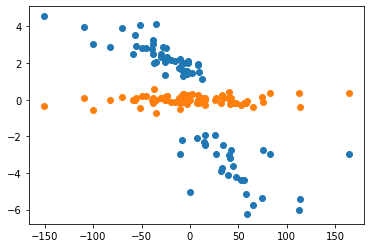

In [419]:
#Check if independent vars are linearly correlated with CIR

#blue: negative corr
plt.scatter(df_demean['CrimeIndexRatio'], df_demean['CPI']) 

#orange: veryyyy slight positive corr, flattened because of y-scale
plt.scatter(df_demean['CrimeIndexRatio'], df_demean['UnemploymentRate']) 

This looks a lot better now. Both independent variables are quite linearly related to CIR, and unemployment is even, dare we say, slightly positively correlated.

Before proceeding, let's turn the dataframe into a panel dataframe, so our model knows that the data is grouped by state and each state has data fro 2015-2019.


In [438]:
#Set entity index to State, and time index to Year
df = df.set_index(['State','Year'])
df

CrimeIndexRatio  CrimeIndex  Population  \
State             Year                                            
Malaysia          2015           370.50      115544    31186100   
                  2016           355.17      112354    31633500   
                  2017           309.68       99169    32022600   
                  2018           273.80       88662    32382300   
                  2019           256.61       83456    32523000   
...                                 ...         ...         ...   
W.P. Kuala Lumpur 2015           855.75       15946     1863400   
                  2016           906.52       16989     1874100   
                  2017           716.86       13482     1880700   
                  2018           642.59       12127     1887200   
                  2019           592.30       11172     1886200   

                        UnemploymentRate    CPI  
State             Year                           
Malaysia          2015               3.1  112.8  
                  2016               3.4  115.2  
                  2017               3.4  119.5  
                  2018               3.3  120.7  
                  2019               3.3  121.5  
...                                  ...    ...  
W.P. Kuala Lumpur 2015               3.3  112.4  
                  2016               3.3  115.5  
                  2017               3.1  119.8  
                  2018               2.4  121.5  
                  2019               2.6  123.0  

[75 rows x 5 columns]

That looks much better.

### Let's pass this data through our model

In [442]:
from linearmodels import PanelOLS

# Run fixed effects model using data
model2 = PanelOLS.from_formula('CrimeIndexRatio ~ 1 + CPI + UnemploymentRate + EntityEffects', df)
# results2 = model2.fit(cov_type='clustered', cluster_entity=True)
results2 = model2.fit()
print(results2)

                          PanelOLS Estimation Summary                           
Dep. Variable:        CrimeIndexRatio   R-squared:                        0.7235
Estimator:                   PanelOLS   R-squared (Between):             -0.6663
No. Observations:                  75   R-squared (Within):               0.7235
Date:                Fri, Jul 30 2021   R-squared (Overall):             -0.4944
Time:                        23:16:42   Log-likelihood                   -352.89
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      75.895
Entities:                          15   P-value                           0.0000
Avg Obs:                       5.0000   Distribution:                    F(2,58)
Min Obs:                       5.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             75.895
                            

#### What a big difference. 
The summary results now tell us that unemployment rate is positively correlated with crime. Specifically, increasing unemployment rate by 1 percentage point will increase the crime index ratio by 42 points.

Interestingly, inflation (CPI) is negatively correlated with crime. This would be surprising if we had thought that higher inflation means higher living costs, and an inability to make ends meet, thus more property crime.

But it looks like inflation is a good thing for crime levels. Probably because Malaysia's inflation rates have been low and steady, and is a sign of economic growth (which holds down crime), rather than unaffordable living costs.

## So here we are, without the Greek and just a little stats.
The data suggest that in Malaysia, crime levels rise during bad times (high unemployment), and fall when there is economic growth.

Obvious, but some obvious things are still worth questioning. And we uncovered some less obvious things along the way.

The results also suggest that during this pandemic, especially during the prolonged lockdowns, we are likely to see crime levels rise. 

This is also a time when historic data (and ours doesn't stretch back very far) cannot be fully relied upon to predict the future. CPI may no longer be a reliable predictor of crime currently, because rising inflation at the moment is not primarily caused by economic activity, but bottlenecks and shortages in the supply pipeline, and rising fuel costs.

*_Side note: Although some people argue for clustered standard errors when it is likely that standard errors vary by group, there is no need for that here because we did not select a random cluster of states and are now trying to generalise to all states. We already have all the states, and wider standard errors for generalisation purposes are not needed._

_Clustering standard errors will increase standard errors and increase the p-value, making the coefficients statistically insignificant. In other words, UnemploymentRate won't be very useful at predicting._